# Floating-points

This file is modified from 
https://nbviewer.jupyter.org/github/mitmath/18335/blob/master/notes/Floating-Point-Intro.ipynb

Arbitrary real numbers on computers are typically approximated by a set $\mathbb{F}$ of [floating-point numbers](https://en.wikipedia.org/wiki/Floating_point).  Basically, you should think of these as numbers in "scientific notation:"
$$
\pm\underbrace{1.b_1 b_2 b_3 ... _{p-1}}_\textrm{significand} \times 2^e, \;\; b_k =0~\textrm{or}~1
$$
where the $b_k$ are digits of the **significand** in base $2$, the number of digits $p$ is the **precision**, and $e$ is the **exponent**.  That is, the computer actually stores a tuple (*sign*,*exponent*, *significand*), representing *a fixed number of significant digits over a wide range of magnitudes*.

The *exponent* is an integer represented by 10 bits and a sign bit.

**Observe:**
    * How are the set of floating points distributed on the real line? (They are not evenly distrubuted!)
    * Why are they not evenly distributed?

**Important concept:**
    * Relative errors (in the approximation of a real number)

## Entering and working with floating-point values

In [10]:
1.531e7 # a floating-point value 1.531 × 10⁷

1.531e7

In [8]:
bitstring(Float16(1.1))

"0011110001100110"

In [9]:
bitstring(-Float16(1.1))

"1011110001100110"

In [2]:
x = 1/49 # division of two integers produces a floating-point value

0.02040816326530612

Since $1/49 \notin \mathbb{F}$, however, $x$ is actually a *rounded* version of $1/49$, and multiplying it by $49$ will yield something that is close to but *not quite equal to 1*.

In [3]:
x * 49

0.9999999999999999

In [4]:
1 - x * 49

1.1102230246251565e-16

## machine epsilon

*This is about $10^{-16}$ because the default floating-point precision in Julia is **double precision**, with
 * $p=53$ bits of significand.   

* Double precision, called the `Float64` type in Julia (64 bits overall), is used because it is **fast**: double-precision floating-point arithmetic is implemented by dedicated circuits in your CPU.

The precision can also be described by $\epsilon = 2^{p-1}$, which bounds the *relative error* between any element of $\mathbb{R}$ and the closest element of $\mathbb{F}$.  It is returned by `eps()` in Julia:

In [5]:
2.0^-52, eps(), eps(1.0), eps(Float64) # these are all the same thing

(2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16)

In fact, there is typically a small rounding error as soon as you enter a floating-point value, because most decimal fractions are not in $\mathbb{F}$.   This can be seen by either:
* converting to a higher precision with `big(x)` (converts to `BigFloat` [arbitrary-precision](https://en.wikipedia.org/wiki/Arbitrary-precision_arithmetic) value, by default with $p=256 bits$ or about 80 decimal digits)
* comparing to an exact rational — in Julia, `p // q` produces a `Rational` type, which is stored as a pair of integers

In [6]:
# 1.5 is exactly represented in binary floating point:
big(1.5), 1.5 == 3//2

(1.5, true)

In [7]:
# 0.1 is *not* exactly represented
big(0.1), 0.1 == 1//10

(0.1000000000000000055511151231257827021181583404541015625, false)

## Accumulation of roundoff errors

A common mistake is to confuse **precision** with **accuracy**.   A value can be *more accurate* or *less accurate* than the precision (number of digits) with which it is represented.

For example, the value `3.0` in floating point (represented exactly in $\mathbb{F}$) is an exact value for the number of sides of a triangle, but a rather inaccurate approximation for π.

Most commonly, floating-point values are *less accurate* than the precision allows, because **roundoff errors accumulate** over the course of a long computation.   To see this, let us consider the function `y = cumsum(x)` in Julia, which computes
$$
y_k = \sum_{i=1}^k x_i
$$
We will try this for random $x_i \in [0,1)$, and compare to the "exact" value of the sum.  Although `cumsum` is built-in to Julia, we will write our own version so that we can see exactly what it is doing:

In [2]:
function my_cumsum(x)
    y = similar(x) # allocate an array of the same type and size as x
    y[1] = x[1]
    for i = 2:length(x)
        y[i] = y[i-1] + x[i]
    end
    return y
end

my_cumsum (generic function with 1 method)

Now, how to we get the "exact" sum for comparing the error?   The trick is that we will do the sum in **two precisions**: *double precision* and *single precision* (Julia `Float32` = 32 bits), where single precision is about 7-8 decimal digits ($p=24$ bits).  Since double precision has about twice as many digits as single precision, we can treat the double precision result as "exact" compared to the single-precision result in order to compute the accuracy in the latter.

In [11]:
eps(Float32), eps(Float64)

(1.1920929f-7, 2.220446049250313e-16)

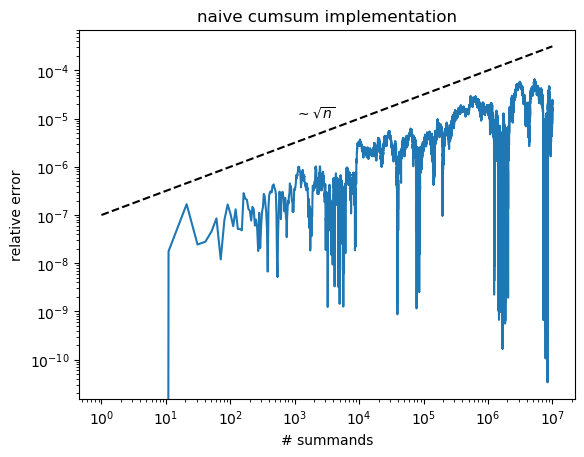

  0.046376 seconds (6 allocations: 38.147 MiB, 4.54% gc time)


PyObject Text(0.5, 1, 'naive cumsum implementation')

In [5]:
x = rand(Float32, 10^7) # 10^7 single-precision values uniform in [0,1)
@time y = my_cumsum(x)

yexact = my_cumsum(Float64.(x)) # same thing in double precision
err = abs.(y .- yexact) ./ abs.(yexact) # relative error in y

using PyPlot
n = 1:10:length(err) # downsample by 10 for plotting speed
loglog(n, err[n])
ylabel("relative error")
xlabel("# summands")

#plot a √n line for comparison
loglog([1,length(err)], sqrt.([1,length(err)]) * 1e-7, "k--")
text(1e3,1e-5, L"\sim \sqrt{n}")
title("naive cumsum implementation")

### The rate of increase of errors
Note that the error starts around $10^{-7}$ (about `eps(Float32)`), but gets worse than the precision as the number of summands grows.

As you can see, the relative error has an upper bound that scales roughly proportional $\sqrt{n}$ where $n$ is the number of summands.   Intuitively, there is a little roundoff error from each addition, but the roundoff error is somewhat random in $[-\epsilon,+\epsilon]$ and hence the roundoff errors grow as a [random-walk](https://en.wikipedia.org/wiki/Random_walk) process $\sim \sqrt{n}$.

### Presentation of results
Note that the horizontal and vertical axes are scaled.
If no scaling, we will have a harder time reading the important information from the computed results.

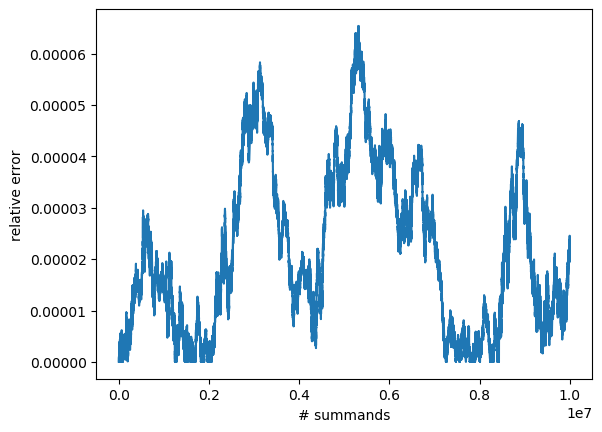

PyObject Text(0.5, 24.0, '# summands')

In [6]:
n = 1:10:length(err) # downsample by 10 for plotting speed
plot(n, err[n])
ylabel("relative error")
xlabel("# summands")

However, **one can do better than this**.  

The improvement uses the so-called "compensated summation" (or Kahan summation, https://en.wikipedia.org/wiki/Kahan_summation_algorithm), which "adds back" some of the lost significant bits to the sum.

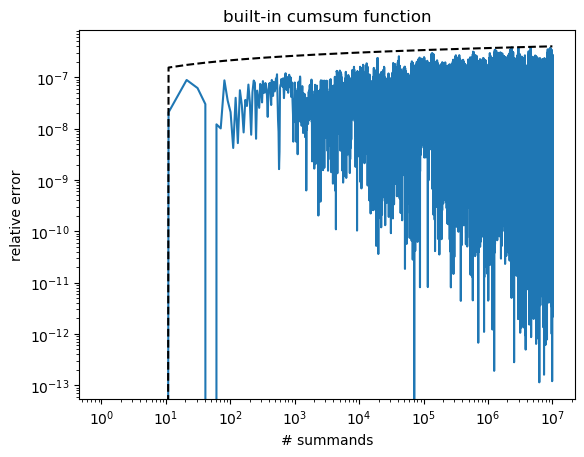

  0.093665 seconds (208.37 k allocations: 48.586 MiB, 10.73% gc time)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14cf64240>

In [4]:
VERSION < v"0.3.6" && warn("cumsum is less accurate for Julia < 0.3.6")
@time y2 = cumsum(x)
err2 = abs.(y2 .- yexact) ./ abs.(yexact)
loglog(n, err2[n])
ylabel("relative error")
xlabel("# summands")
title("built-in cumsum function")
loglog(n, sqrt.(log.(n)) * 1e-7, "k--")

## Rounding mode

By default, each elementary floating-point operation (`+`, `-`, `*`, `/`) behaves as if it computed its result in infinite precision and then rounded the result to the *nearest* floating-point value (rounding to the nearest *even* value in the case of ties).  This is called **correct rounding** or **exact rounding**.

The `rounding` function in Julia returns the current rounding behavior for a given type, and defaults to rounding to the nearest value:

In [7]:
rounding(Float32)

RoundingMode{:Nearest}()

However, it is possible to *change* the rounding mode to always round *up* (or *down*) with the `setrounding` function from the [SetRounding.jl package](https://github.com/JuliaIntervals/SetRounding.jl).  (In C/C++ you would use the [`fesetround`](https://en.cppreference.com/w/c/numeric/fenv/feround) function.)

First, let's install this package if needed.  We can do `import Pkg` followed by `Pkg.add("SetRounding")`, but it is nicer to simply start an input cell with `]` at which point you are in "package mode" and have a set of [nice package-management commands](https://docs.julialang.org/en/v1/stdlib/Pkg/) available:

In [9]:
] add SetRounding

 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]


In [10]:
using SetRounding

Changing the rounding mode is supported in the CPU hardware, so it doesn't change the speed of floating-point arithmetic.   It can be extremely useful to gain an understanding of the roundoff errors in a problem, and can even be used to implement [interval arithmetic](https://en.wikipedia.org/wiki/Interval_arithmetic), in which you compute a range `[a,b]` that bounds your error rather than a single rounded value — see [IntervalArithmetic.jl](https://github.com/JuliaIntervals/IntervalArithmetic.jl) in Julia. 

In the case of our summation problem, we can change to rounding up, which will result in a very different error growth: O(n) rather than O(√n).  The errors now all accumulate in the same direction, so they no longer form a random walk

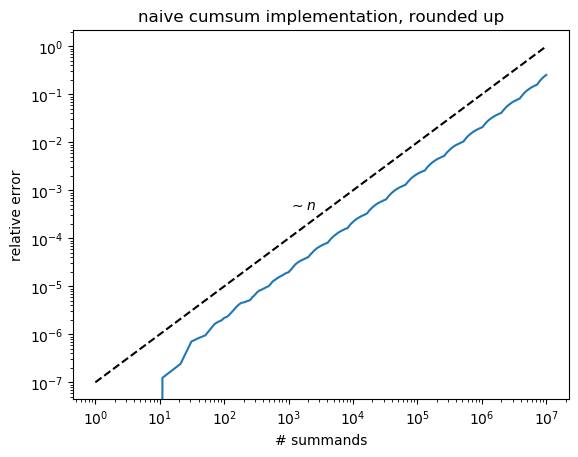

PyObject Text(0.5, 1, 'naive cumsum implementation, rounded up')

In [11]:
errup = setrounding(Float32, RoundUp) do
    # error in single-precision (Float32) sum, rounding temporarily set to RoundUp
    abs.(my_cumsum(x) .- yexact) ./ abs.(yexact) # relative error in y
end

loglog(n, errup[n])
ylabel("relative error")
xlabel("# summands")
# plot an O(n) line for comparison
loglog([1,length(errup)], [1,length(errup)] * 1e-7, "k--")
text(1e3,4e-4, L"\sim n")
title("naive cumsum implementation, rounded up")